# Method 1. TF-IDF + MLP classifier.

In [0]:
# for data preprocessing
import numpy as np
import pandas as pd
import nltk
import json
import re

In [0]:
def standardize_df(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace(r"\S+@\S+.com", " ")
    df[text_field] = df[text_field].str.replace(r"@\S+", " ")
    df[text_field] = df[text_field].str.replace(r"http\S+", " ")
    df[text_field] = df[text_field].str.replace(r"http", " ")
    df[text_field] = df[text_field].str.replace(r"rt ", " ")
    df[text_field] = df[text_field].str.replace(r"\d+", " ")
    # df[text_field] = df[text_field].str.replace(r"\n", " ")
    df[text_field] = df[text_field].str.replace(r"#", " ")
    # df[text_field] = df[text_field].str.replace(r"[^A-Za-z!?.,;]", " ")
    return df

def standardize_text(text):
    text = [w.lower() for w in text]
    text = [re.sub(r'\S+@\S+.com', ' ', w) for w in text]
    text = [re.sub(r'@\S+', ' ', w) for w in text]
    text = [re.sub(r'http\S+', ' ', w) for w in text]
    text = [re.sub(r'http', ' ', w) for w in text]
    text = [re.sub(r'rt ', ' ', w) for w in text]
    text = [re.sub(r'\d+', ' ', w) for w in text]
    # text = [re.sub(r'\n', ' ', w) for w in text]
    text = [re.sub(r'#', ' ', w) for w in text]
    # text = [re.sub(r'[^A-Za-z!?.,;]', ' ', w) for w in text]
    return text

def remove_duplicates_df(df, text_filed):
    '''
    This function removes words like "a", "aa", "aaa"...
    '''
    texts = []
    for text in df[text_filed]:
        words = text.split(" ")
        for w in text.split(" "):
            if ((len(w) >= 1) and len(set(list(w))) == 1):
                words.remove(w)
        texts.append(" ".join(words))
    df[text_filed] = texts
    return df

def remove_duplicates_text(text):
    '''
    This function removes words like "a", "aa", "aaa"...
    '''
    texts = []
    for text in text:
        words = text.split(" ")
        for w in text.split(" "):
            if ((len(w) >= 1) and len(set(list(w))) == 1):
                words.remove(w)
        texts.append(" ".join(words))
    return texts

def read_data_json(file_name):
    '''
    This function takes the file name of the json file as input,
    and then return a DataFrame as output.
    '''
    text = []
    label = []
    with open(file_name, 'r') as f:
        data = json.load(f)
        for elm in data.values():
            text.append(elm['text'])
            label.append(elm['label'])
    data = {'text': text, 'label': label}
    data = pd.DataFrame.from_dict(data)
    return data

def read_negative_data(file_name):
    '''
    This function takes the file name of the json file as input,
    and then return a DataFrame as output.
    '''
    text = []
    label = []
    with open(file_name, 'r') as f:
        df = json.load(f)
    data = {'text': df['text'], 'label': df['label']}
    data = pd.DataFrame.from_dict(data)
    return data

## Import Dataset

In [0]:
negative_data_df = read_negative_data("negative_data.json")
train_data_df = read_data_json("train.json")

train_data = [negative_data_df, train_data_df]
train_df = pd.concat(train_data).reset_index(drop=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

dev_df = read_data_json("dev.json")

train_df = standardize_df(train_df, 'text')
train_df = remove_duplicates_df(train_df, 'text')
dev_df = standardize_df(dev_df, 'text')
dev_df = remove_duplicates_df(dev_df, 'text')

X_test = []
with open("test-unlabelled.json", 'r') as f:
    data = json.load(f)
    for val in data.values():
        X_test.append(val['text'])
X_test = standardize_text(X_test)
X_test = remove_duplicates_text(X_test)

X_train = train_df['text'].tolist()
X_dev = dev_df['text'].tolist()

y_train = train_df['label'].tolist()
y_dev = dev_df['label'].tolist()


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

def get_metrics(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')   
    
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    accuracy = accuracy_score(y_test, y_predicted)

    return accuracy, precision, recall, f1

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [5]:
clf_tfidf = MLPClassifier()
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_dev = clf_tfidf.predict(X_dev_tfidf)
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_dev, y_predicted_dev)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, 
                                                                       precision_tfidf, 
                                                                       recall_tfidf, 
                                                                       f1_tfidf))
cm2 = confusion_matrix(y_dev, y_predicted_dev)
print(cm2)

accuracy = 0.840, precision = 0.841, recall = 0.840, f1 = 0.840
[[43  7]
 [ 9 41]]


In [0]:
y_predict = clf_tfidf.predict(X_test_tfidf).tolist()
with open('test-unlabelled.json', 'r') as f:
    data = json.load(f)

result = {}
i = 0
for key, val in data.items():
    result[key]  = {"label":  y_predict[i]}
    i += 1
with open('test-output.json', 'w') as f:
    json.dump(result, f)

# Plot out the features extracted by tfidf vectorizer. 
As we can see, it seperates 2 classes good enough. But there are still a decent amount of features cannot be seperated. And this is not surprising.

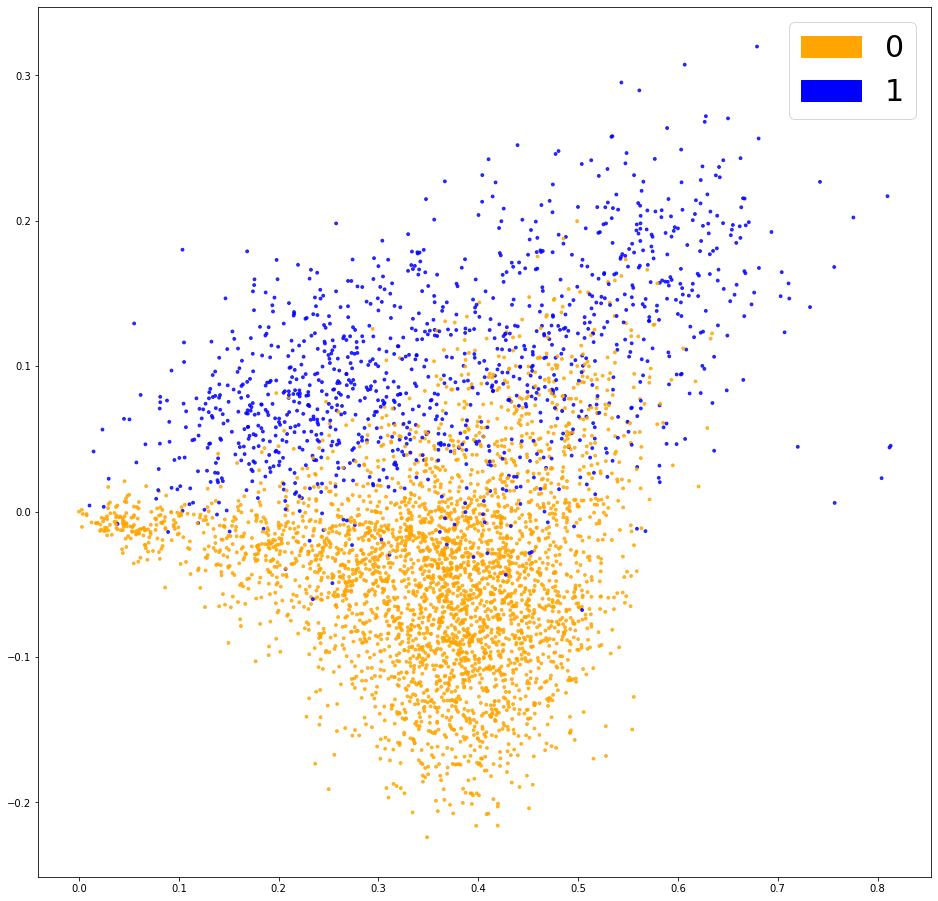

In [7]:
# ***********************************************************
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='0')
            green_patch = mpatches.Patch(color='blue', label='1')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()


# Method 2. Keras Model with Pre-trained Base Bert Model from Google. 

## Prepare for modelling

In [8]:
# for modelling
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# for BERT
import tensorflow_hub as hub

nltk.download('words')

# use the tokenizaor from Google Team
import urllib.request
url = 'https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py'
filename = 'tokenization.py'
urllib.request.urlretrieve(url, filename)
# !wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece
import tokenization

# prepare bert. Following bert-related codes are written based on the tutorial given below.
# https://www.kaggle.com/ratan123/in-depth-guide-to-google-s-bert#notebook-container
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    clf_output = Dropout(0.5)(clf_output)
    clf_output = Dense(65)(clf_output)
    clf_output = Dropout(0.5)(clf_output)
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['acc'])
    
    return model

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
# module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()  # #no need to lower here as we have lowerred it before.

tokenizer = tokenization.FullTokenizer(vocab_file)

Using TensorFlow backend.


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
     |████████████████████████████████| 1.0MB 6.6MB/s 


## Import Dataset

In [0]:
negative_data_df = read_negative_data("negative_data.json")
train_data_df = read_data_json("train.json")

train_data = [negative_data_df, train_data_df]
train_df = pd.concat(train_data).reset_index(drop=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

dev_df = read_data_json("dev.json")

# According to Google's benchmarks, I fine-tuned the max_length to 512 and batch_size to 4.
# https://github.com/google-research/bert
max_length = 512

def convert_input(df, tokenizaor=tokenizer, max_len=max_length):
    df = standardize_df(df, "text")
    df = remove_duplicates_df(df, "text")
    
    x = bert_encode(df['text'], tokenizer, max_len=max_length)
    return df, x

train_df, train_input = convert_input(train_df)
dev_df, dev_input = convert_input(dev_df)

test_input = []
with open("test-unlabelled.json", 'r') as f:
    data = json.load(f)
    for val in data.values():
        test_input.append(val['text'])
test_input = standardize_text(test_input)
test_input = remove_duplicates_text(test_input)
test_input = bert_encode(test_input, tokenizer, max_len=max_length)

train_labels = train_df['label'].values
dev_labels = dev_df['label'].values

## Train the model

In [13]:
model = build_model(bert_layer, max_len=max_length)
model.summary()

# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_labels),
#                                                  train_labels)
# class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights = {0: 30., 1: 10.} # fine-tuned this class weights based on lots of trails
print(class_weights)
model.fit(
    train_input, train_labels,
    validation_data=(dev_input, dev_labels),
    epochs=5,
    batch_size=4,
    class_weight=class_weights,
    verbose=True
)

# model.save('saved_model')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

## Evaluate with dev.json

In [16]:
from sklearn.metrics import confusion_matrix
loss, accuracy = model.evaluate(dev_input, dev_labels, verbose=False)
print(accuracy)
predict_test = model.predict(test_input)

0.8600000143051147


## Use customized rule to predict classes, and save predictions of test.json

In [0]:
def predict_classes(prob, threshold=0.5):
    result = []
    for i in prob.tolist():
        if (i[0] < threshold):
            result.append(0)
        else: 
            result.append(1)
    return result

ts = 0.95 # fine-tuned this threshold based on a lot of trails
predict = predict_classes(predict_test, ts)

with open('test-unlabelled.json', 'r') as f:
    data = json.load(f)

result = {}
i = 0
for key, val in data.items():
    result[key]  = {"label":  int(predict[i])}
    i += 1
with open('test-output.json', 'w') as f:
    json.dump(result, f)